In [1]:
%%html 
<style>
    #btable, th, tr, td {border:none!important}
</style>

## An open science approach to a recent false-positive between solar activity and the Indian monsoon## 

**Summary:** A litany of research has been published claiming strong Solar influences on the Earth's weather and climate. Much of this work includes documented errors and false-positives, yet is still frequently used to substantiate arguments of global warming denial. [Badruddin & Aslam (2015)](http://www.sciencedirect.com/science/article/pii/S1364682614002697), which I shall also refer to as BA15 for convenience, have recently reported a link between solar activity and extremes in the Indian Monsoon. They further speculated that the relationship they observed may apply across the entire tropical and sub-tropical belt, and be of global importance. However, their statistical analysis rested on the assumption that their data followed a Student's $t$-distribution. This notebook reproduces their results, and demonstrates why their claims are unsupported by their analysis.

The main error of BA15 resulted from the assumption that their datasets distribution was Gaussian, this assumption was built into their statistical test. However, as demonstrated below, their data closely follow an ergodic chaotic distribution biased towards extreme values. From a probability density function (PDF), calculated using a Monte Carlo (MC) sampling approach, I show that far from being uncommon, the samples they obtained are actually from the most statistically likely portion of the distribution.

Authour: Benjamin A. Laken

<table id="btable" width='320' cellspacing='0' cellpadding='0' border-spacing='0' style="width:320px;margin:0;padding:0;">
  <tr>
    <td>
      <a href="http://www.benlaken.com" target="_blank" title="ProfilePic" style="border:none;text-decoration:none;">
        <img src="http://www.files.benlaken.com/documents/sig_attribs/prf_icon.png" alt="Profile_Image" style="border:none;width:80px;height:80px;">
      </a>
    </td>

    <td>
            <a href="http://www.mn.uio.no/geo/english/people/aca/metos/blaken/" target="_blank" title="Twitter" style="text-decoration:none;">
              <img src="http://www.files.benlaken.com/documents/sig_attribs/uio.png" alt="Profile_Image" style="border:none;width:30px;height:30px;"></a>
    </td>

    <td>
     	<a href="https://twitter.com/benlaken" target="_blank" title="Twitter" style="border:none;text-decoration:none;"><img src="http://www.files.benlaken.com/documents/sig_attribs/twt.png" alt="Profile_Image" style="border:none;width:30px;height:30px;"></a>
    </td>

    <td>
        <a href="https://www.youtube.com/user/DrBenLaken" target="_blank" title="Youtube" style="border:none;text-decoration:none;">
              <img src="http://www.files.benlaken.com/documents/sig_attribs/ytube.png" alt="Profile_Image" style="border:none;width:30px;height:30px;"></a>
    </td>
    
    <td>
            <a href="https://www.researchgate.net/profile/Benjamin_Laken" target="_blank" title="RG" style="border:none;text-decoration:none;">
              <img src="http://www.files.benlaken.com/documents/sig_attribs/RG_logo.png" alt="Profile_Image" style="border:none;width:30px;height:30px;"></a>
    </td>
    
    <td>
            <a href="https://impactstory.org/BenjaminLaken" target="_blank" title="impactstory" style="border:none;text-decoration:none;">
              <img src="http://www.files.benlaken.com/documents/sig_attribs/impact.png" alt="Profile_Image" style="border:none;width:30px;height:30px;"></a>
    </td>
    
  </tr>
</table>

In [2]:
# Code is compatible with either Python 2.7 or 3.X
# NB. past module required for python 3 users (https://pypi.python.org/pypi/past)
from __future__ import print_function, division, generators
import sys
print("Running Python {0}.{1}".format(  
    sys.version_info[:2][0],sys.version_info[:2][1]))
if sys.version_info[:2] > (3, 0):
    print("Adding xrange for backwards compatibility".format(
            sys.version_info[:2][0],sys.version_info[:2][1]))
    from past.builtins import xrange
#from __future__ import print_function,division,generators
%pylab inline
from scipy.stats.stats import pearsonr
import pandas as pd
import datetime as dt
from scipy.stats import kendalltau
import seaborn as sns
from random import randrange
sns.set(style="darkgrid")  # Optionally change plotstyle ('whitegrid', 'ticks','darkgrid')

Running Python 3.4
Adding xrange for backwards compatibility
Populating the interactive namespace from numpy and matplotlib


/Users/Ben/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### 1. Read data###

Fetch the required data from CSV files held on a public server. Then automatically create date objects, and remove the original date column (leaving it only as an index).

In [3]:
webpth = 'http://www.files.benlaken.com/documents/'

monsoon = pd.read_csv(webpth+'Monsoon_data.csv', parse_dates=['Date'])
monsoon.index = monsoon.Date
monsoon = monsoon.drop('Date', 1) 

olou = pd.read_csv(webpth+'Olou_counts.csv',parse_dates=['Date'])
olou.index = olou.Date
olou = olou.drop('Date', 1) 

### 2. Explore the data ###

Some plots to give you an idea of what we are working with.

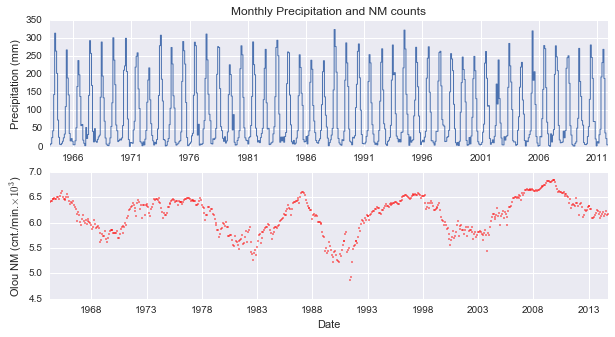

In [4]:
# Plot the simple time series 
my_ts = plt.figure()
my_ts.set_size_inches(10,5)         # Specify the output size
ax1 = my_ts.add_subplot(211)        # Add an axis frame object to the plot (i.e. a pannel)
ax2 = my_ts.add_subplot(212) 

ax1.step(monsoon.index.date,monsoon.Precip,lw=1.0)
ax1.set_title(r'Monthly Precipitation and NM counts')
ax1.set_ylabel(r'Precipitation (mm)')
ax1.grid(True)
#ax1.set_yscale('log')

ax2.plot(olou.index.date,olou.Counts/1000,'r.',ms=3.0)
ax2.set_ylabel(r'Olou NM (cnt./min.$\times10^{3}$)')
ax2.set_xlabel('Date')
ax2.grid(True)
plt.show(my_ts)
my_ts.savefig('Monthly_ts.pdf',dpi=300)

In [5]:
def return_stderr(data):
    """Calculate uncertainty of a np array as Standard Error of the Mean"""
    return np.nanstd(data)/np.sqrt(np.count_nonzero(data) - 1)

climo = {}       # Produce a dic of monthly climatology using list comprehension
climo['means'] = [np.mean(monsoon.Precip[monsoon.index.month == (mnth+1)])
                  for mnth in xrange(12)]
climo['error'] = [return_stderr(monsoon.Precip[monsoon.index.month == (mnth+1)].values) 
                    for mnth in xrange(12)]

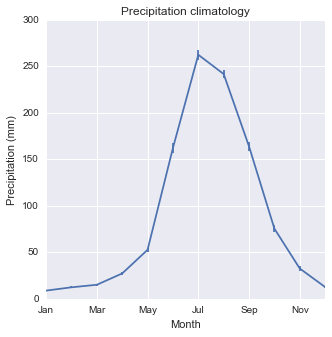

In [6]:
# -- Plot the climatology --
my_climo = plt.figure()
my_climo.set_size_inches(5,5)
ax1 = my_climo.add_subplot(111)
ax1.errorbar(x=range(12),y=climo['means'],yerr=climo['error'])
ax1.set_title(r'Precipitation climatology')
ax1.set_ylabel(r'Precipitation (mm)')
ax1.set_xlabel(r'Month')
ax1.set_xlim(0,11)
ax1.set_xticklabels(labels=['Jan','Mar','May','Jul','Sep','Nov'])
ax1.grid(True)
plt.show(my_climo)
my_climo.savefig('Monthly_climo.pdf',dpi=300)

In [7]:
# Calculate monthly 𝛿 precip. (anomaly with respect to seasonal climatology)
delta = []
for date in monsoon.Precip.index:
    delta.append(monsoon.Precip[date] - climo['means'][date.month-1])
dseries = pd.Series(delta, index=monsoon.index)

In [11]:
# Create a dictionary of May, June, July, August and September data
def lookup_index(yr):
    return ((monsoon.index.year == yr) & (monsoon.index.month >= 5) 
           &(monsoon.index.month <= 9))
mjjas = {}
mjjas['means']=[np.mean(dseries[lookup_index(yr)]) for yr in xrange(1964,2012,1)]
mjjas['SEM']=[return_stderr(dseries[lookup_index(yr)])for yr in xrange(1964,2012,1)]
mjjas['sum']=[np.sum(dseries[lookup_index(yr)]) for yr in xrange(1964,2012,1)]

/Users/Ben/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


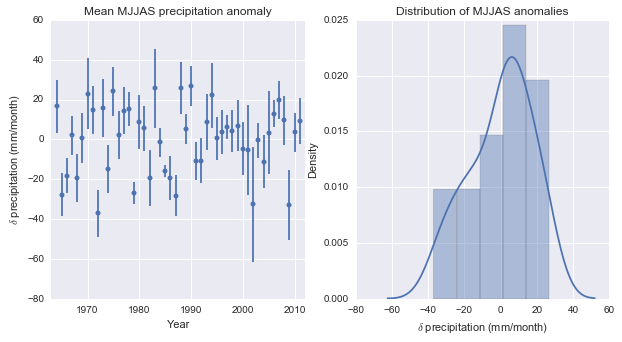

In [15]:
# Plot precipitation anomaly
sns.set(style="darkgrid")
yrange = xrange(1964,2012,1)
my_mjjas = plt.figure()
my_mjjas.set_size_inches(10,5)
ax1 = my_mjjas.add_subplot(121)
ax2 = my_mjjas.add_subplot(122)

ax1.errorbar(x=yrange,y=mjjas['means'],yerr=mjjas['SEM'],fmt='.',ms=10)
ax1.set_xlim(min(yrange)-1,max(yrange)+1)
ax1.set_title(r'Mean MJJAS precipitation anomaly')
ax1.set_ylabel(r'$\delta$ precipitation (mm/month)')
ax1.set_xlabel(r'Year')
ax1.grid(True)

sns.distplot(mjjas['means'], ax = ax2)
ax2.set_title("Distribution of MJJAS anomalies")
ax2.set_xlabel(r"$\delta$ precipitation (mm/month)")
ax2.set_ylabel("Density")

plt.show(my_mjjas)
my_mjjas.savefig('delta_precip_pop.pdf',dpi=300)

### 3. Composites of $\delta$ precip. from $r$-values from 'Drought' and 'Flood'  years    ###

[Badruddin & Aslam (2015)](http://www.sciencedirect.com/science/article/pii/S1364682614002697) took the largest/smallest 12 years of 𝛿 precipitation data, and composited corresponding Oulu pressure-adjusted neutron monitor count (counts per min) data during the May--September months for these 12 years. He calculated the linear regressions of these composites, obtaining a Pearson's *r*-value and *p*-value. They found that during the drought (D) composite the $r$ values were negative, while during the flood (F) composite the *r*-value was positive. The associated *p*-values appear to be statistically significant, however, these *p*-values are based on a Student's t-test (assuming a Gaussian distribution).


|Drought | Flood
| ------------- |:-------------:| -----:|
|1965  | 1964|
|1966 | 1970|
|1968 | 1971|
|1972 |1973|
|1974  |1975|
|1979 |1978|
|1982  |1983|
|1986 |1988|
|1987  |1990|
|2002 |1994|
|2004  |2007|
|2009 |2008|



In [16]:
def make_cframe(c_years):
    '''
    Function to take a list of composite years (c_years)
    and create a numpy array (c_years, months) for analysis.
    Also returns back a month-wise set of means, and SEM values.
    '''
    c_group = np.zeros((12,12),dtype=float) 
    for n, yr in enumerate(c_years):
        tmp = olou.index.year == yr
        for i in xrange(len(olou.Counts[tmp])):
            c_group[n,i] = olou.Counts[tmp][i]
    aaa = np.where(c_group == 0)
    c_group[aaa] = np.nan
    c_means = []
    c_errors = []
    for i in xrange(12):
        c_means.append(np.nanmean(c_group[:,i]))   # per month, all years
        c_errors.append(return_stderr(c_group[:,i]))
    return c_group,c_means,c_errors

In [17]:
drought_years = [1965, 1966, 1968, 1972, 1974,1979,
                 1982, 1986, 1987, 2002, 2004, 2009]

flood_years = [1964, 1970, 1971, 1973, 1975, 1978, 
               1983, 1988, 1990, 1994, 2007, 2008]

d_group,d_means,d_errors = make_cframe(drought_years)
f_group,f_means,f_errors = make_cframe(flood_years)

d_means = np.array(d_means) * 0.001
f_means = np.array(f_means) * 0.001
d_errors = np.array(d_errors) * 0.001    # Make the values smaller for plotting
f_errors = np.array(f_errors) * 0.001

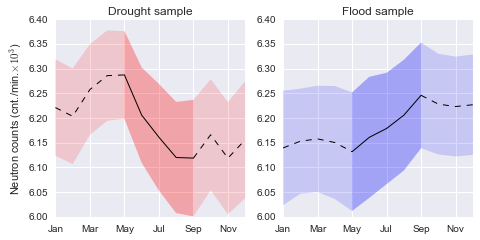

In [18]:
# Create a composite plot of the BA15 data. Emphasise the May to September period 
# without removing the rest of the data. This is useful for people to see. 
# Use diffrent line properties to acheive this effect.

def simBA15plot(ax, dataset, derr, col_key):
    """
    Set the plot and properties of the figure sub-pannels.
    """
    lthick=1.0
    ax.plot(mrange[0:5], dataset[0:5], 'k--',lw=lthick)  # Jan to May
    ax.plot(mrange[4:9], dataset[4:9], 'k-',lw=lthick)   # May to Sep
    ax.plot(mrange[8:], dataset[8:], 'k--',lw=lthick)    # Sep to Dec
    ax.fill_between(mrange[0:5],(dataset[0:5] - derr[0:5]),
                    (dataset[0:5] + derr[0:5]), color=col_key, linewidth=0.1,alpha=0.15)
    ax.fill_between(mrange[4:9], (dataset[4:9] - derr[4:9]), (dataset[4:9] + derr[4:9]),
                    color=col_key, linewidth=0.1, alpha=0.3)
    ax.fill_between(mrange[8:],(dataset[8:] - derr[8:]), (dataset[8:] + derr[8:]),
                    color=col_key, linewidth=0.1, alpha=0.15)
    ax.set_xticklabels(xlabs)
    ax.set_xlim(0,11)
    return

mrange = arange(0,12)
xlabs =['Jan','Mar','May','Jul','Sep','Nov']

figBA15 = plt.figure()
figBA15.set_size_inches(7.48,3.54)
ax1 = figBA15.add_subplot(121)          
ax2 = figBA15.add_subplot(122) 
simBA15plot(ax=ax1, dataset=d_means, derr=d_errors, col_key='r')
simBA15plot(ax=ax2, dataset=f_means, derr=f_errors, col_key='b')
ax1.set_ylabel(r"Neutron counts (cnt./min.$\times10^{3}$)", fontsize=11)
ax1.set_title('Drought sample')
ax2.set_title('Flood sample')
plt.show(figBA15)
figBA15.savefig('Composite_samples.pdf',dpi=300)

In [19]:
# BA15 used 5 months starting in May (position 4 in the array)
# Confirmed: these are the r-values BA15 obtained
rval_d,pval_d = pearsonr(xrange(5),d_means[4:9])
rval_f,pval_f = pearsonr(xrange(5),f_means[4:9])
print("A Pearson's r test, gives linear regressions and two-tailed p-values of:")
print("Drought sample: r-value = {0:4.3f}, p-value = {1:4.3f}".format(rval_d, pval_d))     
print("Flood sample: r-value = {1:4.3f}, p-value = {1:4.3f}".format(rval_f, pval_f))

A Pearson's r test, gives linear regressions and two-tailed p-values of:
Drought sample: r-value = -0.949, p-value = 0.014
Flood sample: r-value = 0.001, p-value = 0.001


Indeed, based on the significance of the $r$-values alone it would seem that there are significant correlations between steep changes in the cosmic ray flux and extremes of the Indian Monsoon. This is the core finding reported by BA15. However, the statistical test applied assumes the data are roughly Gaussian. This is impossible for these data, as they are monthly time-scale composites of the solar cycle, which is essentially a sine wave.

I will now demonstrate how this fact impacts the distribution of these data:

### 4. Bootstrap to identify the possible $r$-values of the samples ###
Assuming any value within the SEM range is equally possible, what are the r-values that may be true.

In [20]:
# Some more functions...
def bootstrap_r(mean_list, error_list, iterations=1000):
    """
    Bootstrap info. Error and means are set up to accept data from make_cframe()
    which is why the offsets within the arrays have been hard-coded to the months
    of key interest (monsoon period).
    Guess a possible min and max (poss_min/max) values based on observed mean and 
    calculate SEM values. Assume an equal chance of any value in that range occurring.
    For a specified number of realization (controlled by iterations) calculate the 
    r-value and p-value, of the linear correlation. Save them to a MC array.
    """
    bs_rvals = []
    bs_pvals = []
    for itr in xrange(iterations):
        poss_vals = []   # List for possible values of CR flux
        for n in range(5):
            #nb. Below factor preserves sig. figs. in change float > ints
            poss_min = int((mean_list[4 + n] - error_list[4 + n]) * 100000) 
            poss_max = int((mean_list[4 + n] + error_list[4 + n]) * 100000)
            poss_vals.append(randrange(poss_min,poss_max)/100)
            #print(4+n,poss_min/100,poss_max/100,poss_vals[-1])
        rv, pv = pearsonr([0,1,2,3,4],poss_vals) # rval, pval
        bs_rvals.append(rv)
        bs_pvals.append(pv)
    bs_rvals = np.array(bs_rvals)
    bs_pvals = np.array(bs_pvals)
    return bs_rvals, bs_pvals


def freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From http://stats.stackexchange.com/questions/798/
    a = np.asarray(a)
    h = 2 * iqr(a) / (len(a) ** (1 / 3))
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return np.sqrt(a.size)
    else:
        return np.ceil((a.max() - a.min()) / h)

    
def iqr(data):
    """Return Inter Quartile Range"""
    q75, q25 = np.percentile(data, [75 ,25])
    return q75 - q25

def add_hist(data, col_key, axobj, mkstyle='o', 
             obsval=None, mylabel=None, bin_num=None):
    """
    Custom Plotting function for histograms.
    data - np.array of values, e.g. generated by bootstrap_r()
    col_key - code for setting color
    axobj - axis object to add the plot to
    mylabel - a label for the plotting legend
    obsval - the observed r-value for comparison (e.g. rval_d)
    mkstyle - matplotlib marker style (default set to circle 'o')
    """
    if not bin_num:
        bin_num = freedman_diaconis_bins(data) #if no bins set, use FD spacing
    hist, bin_edges = np.histogram(data, bins=bin_num, density=False)
    norm_hist = hist / sum(hist) # Normalize the data to show density
    axobj.bar(bin_edges[0:-1], norm_hist, width = bin_edges[1] - bin_edges[0], 
            color = col_key, edgecolor = col_key, alpha = 0.3, label=mylabel)
    mylabel = None
    if obsval:
        lookup = np.where(abs(obsval - bin_edges[0:-1]) == 
                          min(abs(obsval - bin_edges[0:-1])))
        axobj.vlines(obsval,0,norm_hist[lookup], linestyles='dashed',
               lw=1.0, zorder=6, label=mylabel)
        axobj.plot(obsval, norm_hist[lookup], color='k', marker=mkstyle, 
                   ms=5., zorder=7, label=mylabel)

Calculate two arrays: bootstraps assuming that the values within the SEM range have an equal chance of occurring

In [15]:
rbs1, pbs1 = bootstrap_r(mean_list = d_means, error_list = d_errors)
rbs2, pbs2 = bootstrap_r(mean_list = f_means, error_list = f_errors)

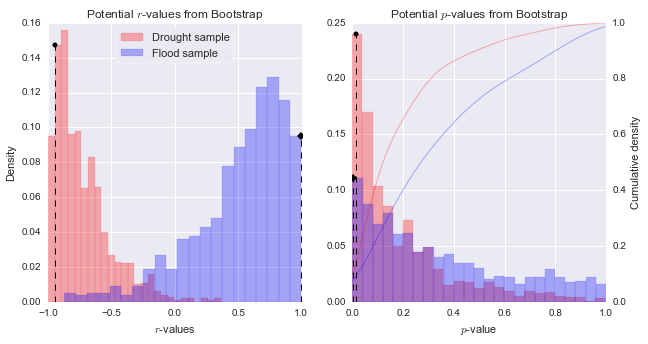

In [16]:
#---- Create plot object 1 (possible r and p-vals)
possible_r = plt.figure()
possible_r.set_size_inches(10,5)
ax1 = possible_r.add_subplot(121)
ax2 = possible_r.add_subplot(122)

# --- Pannel 1 (r-values)
add_hist(data=rbs1, col_key='r', axobj=ax1, obsval=rval_d, 
         mylabel="Drought sample", mkstyle='o')
add_hist(data=rbs2, col_key='b', axobj=ax1, obsval=rval_f, 
         mylabel="Flood sample", mkstyle='D')
ax1.legend(loc=9, prop={'size':11}, numpoints=1, markerscale=5.,
            frameon=True, fancybox=True)

#ax1.set_xlim(-1,1)
ax1.set_ylabel('Density')
ax1.set_xlabel('$r$-values')
ax1.set_title('Potential $r$-values from Bootstrap')

# --- Pannel 2 (p-values)
add_hist(data=pbs1, col_key='r', axobj=ax2, bin_num=25,
        obsval=pval_d, mkstyle='o')
add_hist(data=pbs2, col_key='b', axobj=ax2, bin_num=25,
        obsval=pval_f, mkstyle='D')

ax3 = ax2.twinx()
sns.kdeplot(pbs1, cumulative=True, color='r', ax=ax3, 
            lw=1, alpha=0.3, zorder = 10 )
sns.kdeplot(pbs2, cumulative=True, color='b', ax=ax3, 
            lw=1, alpha=0.3, zorder = 11)
ax3.grid(False)
ax3.set_ylabel("Cumulative density")

ax2.set_title(r'Potential $p$-values from Bootstrap')
ax2.set_xlim(0,1)
ax2.set_xlabel(r'$p$-value')
plt.show(possible_r)
possible_r.savefig('possible_rvals.pdf',dpi=300)

The Bootstrap confirms that when uncertainty is taken into account, the $r$-values of the Drought and Flood composites are most likely to possess opposite, extreme, and statistically significant $r$-values (according to standard significance testing). However, the results do highlight the large uncertainty in the data: within the potential range of mean values for the neutron monitor data, given by the SEM uncertainty, trends may potentially be far weaker ($r$-values closer to 0.0), or even of opposite sign to those resulting from calculations of the simple mean.

From the Bootstrap we can conclude that there is a high chance the $r$-values do show opposing trends, biased towards extreme $r$-values. At face value, this would suggest that the Drought sample is associated with strong (and significant) decreases in the cosmic ray flux, opposite to the Flood sample.

To understand why this correlation does not imply causality however we must examine distributions of $r$-values under the null hypothesis, $H_{0}$, I.e. $r$-values of identical samples dimensions, but in the absence of droughts or floods.

### 5. Generate $r$-values randomly using a Monte Carlo permutation approach ###

Groups of May--September extract from 12 random years and composited. This procedure is repeated thousands of times, building up a null distribution (I.e. a distribution of $r$-values that you can expect to observe in the absence of any forcing). If the Drought and Flood samples occur within a high-density portion of the distribution, the hypothesis that they indicate a relationship to the cosmic ray flux can be rejected.

In [17]:
import random                
def MonteCarlo(s_size,iter_num):
    """
    Monte Carlo function, randomly draws groups of s-size from a
    list of integers representing years from 1964 to 2012. These
    are used as indexes to lookup data from the cosmic ray data
    using the make_cframe() function. R-values identified during 
    key months, and placed into a mc_array. This is repeated for 
    iter_num.
    Nb. the simulations represent realizations of H0, the null 
    hypothesis.
    """
    mc_array = []
    subs = xrange(1964,2012,1)
    for n in xrange(iter_num):
        print('\rLoop {0} of {1}'.format(n,iter_num-1),end='')
        rnd_lookup = random.sample(subs,s_size)
        rnd_group,rnd_means,rnd_errors =make_cframe(rnd_lookup)
        rval,pval = pearsonr([0,1,2,3,4],rnd_means[4:9])    
        mc_array.append(rval)
    mc_array = np.array(mc_array)
    print('\nFinished MC process')
    return mc_array

In [18]:
#mc_array = MonteCarlo(12,100)  # If you want to generate the MC again, uncomment here
#np.savetxt('mc_results.txt',mc_array,fmt='%7.4f')  # Uncomment if you want to save your own MC output here

In [19]:
# Reproduce the specific set of random results which I generated the publication plot from:
# A run of of 100,000 iterations (800kb csv file)
print('Reading MC data from file of earlier runs from public URL...')
tmp =pd.read_csv('http://www.files.benlaken.com/documents/Monsoon_MC_saved.csv')
mc_array = np.array(tmp.mc_results,dtype=float)
tmp=[]

Reading MC data from file of earlier runs from public URL...


For a specified number of bins (bsize), calculate a histogram. Normalize the histogram, so the bins sum add to 1.0 (I.e. indicates density). Also make two fits to the data, one is a Gaussian (this is incorrect), the second is calculated from an $n^{th}$ order polynomial fit.

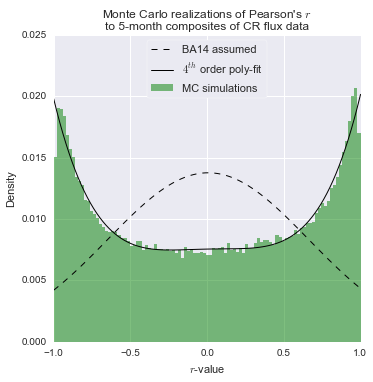

In [20]:
bsize = 101   # Number of bins in histogram
n, bins, patches = ax1.hist(mc_array, bsize, normed=False,
                            facecolor='blue', alpha=0.75,
                            histtype='stepfilled')
density = n/sum(n)

# Center the bins for plotting:
step = (bins[1] - bins[0]) *0.5
bcenter = [bpos + step for bpos in bins[:-1]]

width = bins[1] - bins[0]
xx = np.ravel(zip(bins[0:-1], bins[0:-1] + width))
yy = np.ravel(zip(density, density))

# Calculate a polynomial fit of a specified order
order = 4         # <-- Change order of the polynomial here
z = np.polyfit(bcenter, density, order)
f = np.poly1d(z)
x_new = np.linspace(bins[0], bins[-1], bsize)
y_new = f(x_new)

# Gaussian dist. based on the mean(mu) and stdev(sigma) of MC array
mu, sigma = np.mean(mc_array), np.std(mc_array)
ygauss = normpdf(bins, mu, sigma) # a function from matplotlib.mlab.
ynormgauss = ygauss/sum(ygauss) # Normalize distribution so sum is 1.0


#-----Plotting-----
mc_hist = plt.figure()
mc_hist.set_size_inches(5.5,5.5)             # Specify the output size
ax1 = mc_hist.add_subplot(111)               # Add an axis frame object to the plot
ax1.plot(bins,ynormgauss,'k--',linewidth=1.) # Ideal Gaussian

ax1.bar(bins[0:-1], density, width=width, facecolor='g', 
        linewidth=0.0,alpha=0.5)      # Filled bars
ax1.plot(x_new, y_new,'k-',lw=1)      # Polynomial

ax1.set_ylabel(r'Density',fontsize=11)
ax1.set_xlabel('$r$-value',fontsize=11)

leg1=ax1.legend(['BA14 assumed',r'$4^{th}$ order poly-fit',r'MC simulations'],
                loc=9,prop={'size':11}, numpoints=1, markerscale=5.,
                frameon=True, fancybox=True).get_frame()

ax1.set_title("Monte Carlo realizations of Pearson's $r$ \n" + 
              "to 5-month composites of CR flux data")
ax1.set_ylabel(r'Density',fontsize=11)
ax1.set_xlabel('$r$-value',fontsize=11)

plt.show(mc_hist)
mc_hist.savefig('MC_rvals.pdf',dpi=300)

### 6. Calculate density differences ###

Using a polynomial fit, you can calculate the density for any given $r$-value. Note that this density changes depending on the bin-width of the histogram (a parameter set by bsize above).

In [21]:
print('Polynomial function:')
print(f)

Polynomial function:
         4             3            2
0.01344 x - 8.354e-05 x - 0.001013 x + 0.000259 x + 0.007552


In [22]:
def sumarise(observed, sample_name=""):
    """
    For any given r-value (observed), print out the density predicted
    by a Gaussian fit and a polynomial fit, and compare the values.
    The name of the sample, given as a keyword can also be provided.
    """
    norm_density = normpdf(observed, mu, sigma)/sum(ygauss)
    poly_density = f(observed)
    print("{0} sample (r = {4:3.2f}) \n \
          Gaussian density: {1:4.3f}, Polynomial density: {2:4.3f} \n \
          Overestimatated: x{3:3.1f}".format(
            sample_name, norm_density, poly_density,
            poly_density/norm_density, observed))
    return

In [23]:
sumarise(rval_d, sample_name="Drought")

Drought sample (r = -0.95) 
           Gaussian density: 0.005, Polynomial density: 0.017 
           Overestimatated: x3.7


In [24]:
sumarise(rval_f, sample_name="Flood")

Flood sample (r = 0.99) 
           Gaussian density: 0.004, Polynomial density: 0.020 
           Overestimatated: x4.4


In [25]:
def integrate_fits(start, stop):
    """
    Integrate the Gaussian and polynomial over a specified range 
    to estimate probability.
    
    start - smallest value on x-axis (e.g. r-value range)
    stop - largest position on x-axis (e.g. r-value range)
    """
    cum_density_poly = 0
    cum_density_gauss = 0
    bstep = 2 / bsize
    hw = bstep/2
    for x in arange(start+hw, stop+hw, bstep):
        cum_density_poly += f(x)
        cum_density_gauss += normpdf(x, mu, sigma)/sum(ygauss)
    print("P of r-values from {0:3.2f} to {1:3.2f}".format(start, stop))
    print('Gaussian fit:   {0:3.3f}'.format(cum_density_gauss))
    print('Polynomial fit: {0:3.3f}'.format(cum_density_poly))
    print("")

In [26]:
# examine what should be the significant tails supposing a Gaussian distribution...
integrate_fits(-1, -0.92)

integrate_fits(0.92, 1.0)

P of r-values from -1.00 to -0.92
Gaussian fit:   0.024
Polynomial fit: 0.087

P of r-values from 0.92 to 1.00
Gaussian fit:   0.023
Polynomial fit: 0.094



In [27]:
# Also see how likely it is the population is skewed...
integrate_fits(-1, -0.5)

integrate_fits(0.5, 1.0)

P of r-values from -1.00 to -0.50
Gaussian fit:   0.187
Polynomial fit: 0.309

P of r-values from 0.50 to 1.00
Gaussian fit:   0.187
Polynomial fit: 0.327



Finally, the above integrations highlight that the two-tailed 0.05 confidence interval for the Gaussian fit occurs at positive and negative r-values of around 0.92--1. However, when the same interval is integrated using a 4$^{th}$ order polynomial function, which closely follows the observed distribution, the tails accumulate to a density of 0.18 (0.087 + 0.094). 

This indicates there is an 18% chance that values that would appear as statistically significant ($p$<0.05) in a Gaussian distribution will occur randomly in the sample. 

Plotting the MC distributions has qualitatively shown that these samples are biased to extreme $r$-values. To quantify this, I have integrated the positive and negative $r$-values from 0.5 to 1. The Gaussian fit shows that these combined intervals cover a population density of 0.37 (0.187 + 0.187), while the polynomial fit covers a density of 0.65 (0.327 + 0.327). I.e. In the absence of any hypothetical forcing (e.g. cosmic ray flux), 65% of composite samples should show $r$-values beyond ±0.5. 

### 7. Conclusion###

Contrary to the claims of [Badruddin & Aslam (2015)](http://www.sciencedirect.com/science/article/pii/S1364682614002697), trends in the cosmic ray flux during extremes of the Monsoon were not unusual. The significance of linear regressions of neutron monitor data during Drought and Flood conditions over the Indian Monsoon period are considerably over-estimated by traditional statistical methods, which assumed incorrectly that the data may be accurately represented by a Student's $t$-distribution. 

The correlation coefficients resulting from these data are essentially drawn from ergodic chaotically oscillating data--the inevitable result of compositing monthly time-scale periods randomly over data that follow the Solar Cycle. This led BA15 to considerably over-estimate the statistical significance of their samples and interpret the high $r$-values they obtained as indicative of a physical relationship between the Monsoon and cosmic ray flux. As I have demonstrated however, far from being unusual, the high $r$-values were actually the most common values in the distribution.